In [1]:
import functools

import numpy as np
from collections import defaultdict
# from scipy.special import expit

import pyspark.sql.functions as psf
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import udf, pandas_udf
from pyspark.sql.functions import col
import pyspark.sql as pysql
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, MapType, ArrayType, FloatType, BooleanType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
# from operator import add
# from functools import reduce

pd.set_option('display.max_columns', None)
spark.conf.set('spark.sql.session.timeZone', 'UTC')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
722,application_1648672446715_0724,pyspark,idle,Link,Link,gakumar,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# Reading from local_path 
# local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/data_6mar/"

local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/new_ae_data_20apr/*/*"

df_train = spark.read.parquet(local_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
df = df_train.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(199824, 42)

In [5]:
Cont_cols = ['events_count', 'rx_packets', 'tx_packets', 'rx_ucast_packets',
       'tx_ucast_packets', 'physical_port_count', 'bridge_port_count',
       'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg',
       'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_avg',
       'txpkt_rank_avg', 'rx_upkt_rank_avg', 'tx_upkt_rank_avg',
       'rxpkt_rank_pct', 'txpkt_rank_pct', 'rx_upkt_rank_pct',
       'tx_upkt_rank_pct', 'rx_mcast_packets', 'tx_mcast_packets',
       'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']
# Cat_cols = ['remotecap', 'rmbps', 'bridge']
cat_cols_list = ['remotecap', 'rmbps', 'bridge', 'ae_port']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
remove_cols = [
    'tx_packets', 'rx_root_avg',
    'tx_root_avg',
    'tx_rx_ucast_root_avg',
    'rx_ucast_root_avg',
    'tx_ucast_root_avg',
    'rxpkt_rank_pct',
    'rx_upkt_rank_pct',
    'tx_upkt_rank_pct',
    'rxpkt_rank_avg',
    'tx_upkt_rank_avg',
    'txpkt_rank_pct',
    'physical_port_count'
]

print("Continuous Columns: ", len(Cont_cols))
for col in remove_cols:
    Cont_cols.remove(col)
    
print("Continuous Columns after removal: ", len(Cont_cols))
print("Names: ", Cont_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Continuous Columns:  26
Continuous Columns after removal:  13
Names:  ['events_count', 'rx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'bridge_port_count', 'tx_rx_root_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Site based split

In [9]:
site_list = df["site_id"].unique().tolist()
train, test = train_test_split(site_list, test_size=0.3, random_state=111, shuffle=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
len(train), len(test), len(site_list)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(41, 18, 59)

In [11]:
df_train = df[df["site_id"].isin(train)].reset_index(drop=True)
df_train.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(114965, 42)

In [12]:
df_test = df[df["site_id"].isin(test)].reset_index(drop=True)
df_test.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(84859, 42)

In [13]:
df_train["label"].sum(), df_test["label"].sum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(7900, 3652)

In [14]:
scaling_columns = ['events_count', 'rx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'bridge_port_count', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan']
Scaler = StandardScaler()
df_train.loc[:, scaling_columns] = Scaler.fit_transform(df_train.loc[:, scaling_columns])
df_test.loc[:, scaling_columns] = Scaler.transform(df_test.loc[:, scaling_columns])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
scaler_site = defaultdict(list)
mean_list = Scaler.mean_
std_list = Scaler.scale_
for i, col in enumerate(scaling_columns):
    scaler_site[col].append(mean_list[i])
    scaler_site[col].append(std_list[i])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
for k, v in scaler_site.items():
    print(k, ": ", v)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

events_count :  [41.58569999565085, 42.066262001001995]
rx_packets :  [249296140.4577567, 4248387892.8573494]
rx_ucast_packets :  [244385488.62067586, 4166898321.450365]
tx_ucast_packets :  [14501612.5713565, 507070608.7340439]
bridge_port_count :  [2.137343970429111, 3.0058833464809322]
txpkt_rank_avg :  [21.221940943802682, 22.868277543132905]
rx_upkt_rank_avg :  [27.74682636482497, 30.67872753684398]
rx_mcast_packets :  [3082276.4118035925, 51844275.89628979]
tx_mcast_packets :  [433338.3008393859, 1148191.0487683867]
rx_bcast_packets :  [1838249.6995955291, 30541558.53727898]
tx_bcast_packets :  [600275.9976427609, 1596811.1081718507]
num_vlan :  [3.5021441308224244, 8.734175118462634]

In [19]:
Cont_cols + cat_cols_list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['events_count', 'rx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'bridge_port_count', 'tx_rx_root_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'num_vlan', 'remotecap', 'rmbps', 'bridge', 'ae_port']

#### RandomForest

In [15]:
#Testing RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth = 5, n_jobs = -1, random_state = 111)

clf.fit(df_train[Cont_cols+cat_cols_list], df_train["label"])
y_pred = clf.predict(df_test[Cont_cols+cat_cols_list])

print("Training Accuracy: ", accuracy_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list])), "Validation Accuracy: ", accuracy_score(df_test["label"], y_pred))
print("Training Precision: ", precision_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list])), "Validation Precision: ", precision_score(df_test["label"], y_pred))
print("Training Recall: ", recall_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list])), "Validation Recall: ", recall_score(df_test["label"], y_pred))
print("Training F1-Score: ", f1_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list])), "Validation F1-Score: ", f1_score(df_test["label"], y_pred))

y_predict_probas = clf.predict_proba(df_test[Cont_cols+cat_cols_list])[: , 1]

fpr, tpr, threshold = roc_curve(df_test["label"], y_predict_probas)
roc_auc = auc(fpr, tpr)

f1_max = 0
th_max = 0
for th in np.arange(0.3, 0.9, 0.05):
    f1 = f1_score(df_test["label"], (y_predict_probas>th).astype(int))
    if f1 >= f1_max:
        th_max = th
        f1_max = f1
    
print("Threshold: ", th_max, ", f1-score: ", f1_max)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Accuracy:  0.999808637411386 Validation Accuracy:  0.9983973414723247
Training Precision:  0.9972229235041656 Validation Precision:  0.9853672004417449
Training Recall:  1.0 Validation Recall:  0.9772727272727273
Training F1-Score:  0.9986095310327392 Validation F1-Score:  0.9813032719274126
Threshold:  0.44999999999999996 , f1-score:  0.9842400986706865

In [16]:
# n_estimators=100, max_depth = 5
# Training Accuracy:  0.9996399095452778 Validation Accuracy:  0.9967776335311572
# Training Precision:  0.9993550883528957 Validation Precision:  0.9849397590361446
# Training Recall:  0.994225587065315 Validation Recall:  0.96353591160221
# Training F1-Score:  0.996783738582272 Validation F1-Score:  0.9741202755539007
# Threshold:  0.44999999999999996 , f1-score:  0.9771672545015778

# n_estimators=100, max_depth = 8
# Training Accuracy:  0.9998631656272056 Validation Accuracy:  0.9978208456973294
# Training Precision:  1.0 Validation Precision:  0.985190670122177
# Training Recall:  0.9975619145386886 Validation Recall:  0.980110497237569
# Training F1-Score:  0.9987794693903771 Validation F1-Score:  0.9826440177252584
# Threshold:  0.49999999999999994 , f1-score:  0.9826440177252584

# n_estimators=100, max_depth = 10
# Training Accuracy:  1.0 Validation Accuracy:  0.9981454005934718
# Training Precision:  1.0 Validation Precision:  0.9852670349907919
# Training Recall:  1.0 Validation Recall:  0.9852670349907919
# Training F1-Score:  1.0 Validation F1-Score:  0.9852670349907919
# Threshold:  0.49999999999999994 , f1-score:  0.9852670349907919

# n_estimators=120, max_depth = 8
# Training Accuracy:  0.9998631656272056 Validation Accuracy:  0.9979135756676558
# Training Precision:  1.0 Validation Precision:  0.9852125693160814
# Training Recall:  0.9975619145386886 Validation Recall:  0.9815837937384899
# Training F1-Score:  0.9987794693903771 Validation F1-Score:  0.9833948339483395
# Threshold:  0.44999999999999996 , f1-score:  0.9852670349907919

# n_estimators=120, max_depth = 7
# Training Accuracy:  0.9998631656272056 Validation Accuracy:  0.998075853115727
# Training Precision:  1.0 Validation Precision:  0.9852507374631269
# Training Recall:  0.9975619145386886 Validation Recall:  0.9841620626151013
# Training F1-Score:  0.9987794693903771 Validation F1-Score:  0.9847060991339598
# Threshold:  0.44999999999999996 , f1-score:  0.9852670349907919

# n_estimators=100, max_depth = 6, max_samples=0.9
# Training Accuracy:  0.9998271565817334 Validation Accuracy:  0.9978903931750742
# Training Precision:  0.9998713164328915 Validation Precision:  0.985207100591716
# Training Recall:  0.9970486333889388 Validation Recall:  0.9812154696132597
# Training F1-Score:  0.9984579799537394 Validation F1-Score:  0.9832072338069754
# Threshold:  0.44999999999999996 , f1-score:  0.9841445427728615

# n_estimators=100, max_depth = 5, max_samples=0.9
# Training Accuracy:  0.99967591859075 Validation Accuracy:  0.9969399109792285
# Training Precision:  0.9993555039958752 Validation Precision:  0.9849793466015772
# Training Recall:  0.9948671885025022 Validation Recall:  0.9661141804788214
# Training F1-Score:  0.9971062954150859 Validation F1-Score:  0.9754555596876161
# Threshold:  0.39999999999999997 , f1-score:  0.9817242015875947

# n_estimators=80, max_depth = 6, max_samples=0.9
# Training Accuracy:  0.9998271565817334 Validation Accuracy:  0.9978672106824926
# Training Precision:  0.9998713164328915 Validation Precision:  0.9852016278209397
# Training Recall:  0.9970486333889388 Validation Recall:  0.9808471454880294
# Training F1-Score:  0.9984579799537394 Validation F1-Score:  0.9830195644149132
# Threshold:  0.44999999999999996 , f1-score:  0.983582364877329

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

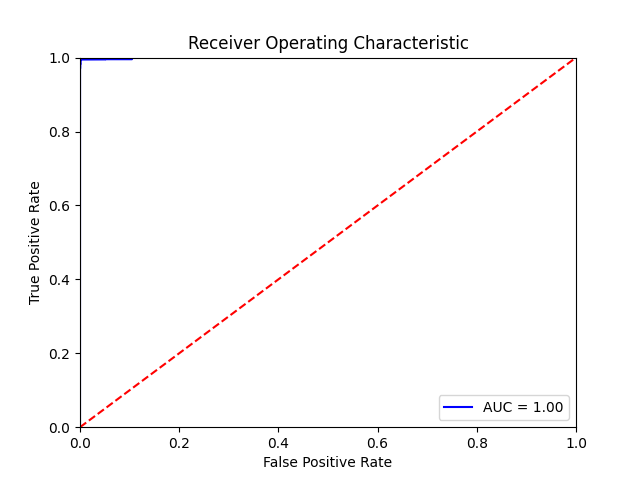

In [17]:
# Plotting ROC Curve
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

%matplot plt

In [18]:
clf_rf_site = deepcopy(clf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Model Predictions

In [2]:
date = '2022-04-06'
hr = '11'
hours = ['09', '10', '11']
env = 'production'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
def read_hourly_data(s3_path, hours):
    final_df = None
    for hr in hours:
        print('reading data for hr: {0}'.format(hr))
        _s3_path = s3_path.format(hr=hr)
        print('reading from s3')
        df = spark.read.parquet(_s3_path)
        print(df.count())
        if final_df is None:
            final_df = df
        else:
            _col1 = set(final_df.columns)
            _col2 = set(df.columns)
            for c in list(_col1.difference(_col2)):
                df = df.withColumn(c, psf.lit(''))
            for c in list(_col2.difference(_col1)):
                final_df = final_df.withColumn(c, psf.lit(''))
            final_df = final_df.unionByName(df)
    print('total records: {0}'.format(final_df.count()))
    return final_df

oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr={hr}/*'

df_hrs = read_hourly_data(oc_stats_s3_path, hours)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reading data for hr: 09
reading from s3
286231
reading data for hr: 10
reading from s3
286774
reading data for hr: 11
reading from s3
286763
total records: 859768

In [21]:
def predict_prob(df, coefficients, intercept, threshold):
    features = []
    coef = []
    for k, v in coefficients.items():
        features.append(k)
        coef.append(float(v))
    df = df.withColumn('uplink_prob_score', F.when(F.col('events_count') >= 10,
                                                   predict_uplink_udf(F.struct(*features),
                                                                      F.array([F.lit(x) for x in coef]),
                                                                      F.lit(intercept))
                                                   ).otherwise(0.0)).withColumn(
        'uplink_value_threshold', F.when(F.col('uplink_prob_score') >= threshold, 1).otherwise(0))
    return df


@udf(returnType=IntegerType())
def phy_count_udf(interfaces, device_type):
    return len(
        [interface for interface in interfaces if
         get_port_type(interface['name'], interface['media_type'], device_type) == 'phy'])


@udf(returnType=IntegerType())
def active_phy_count_udf(interfaces, device_type):
    return len([interface for interface in interfaces if
                get_port_type(interface['name'], interface['media_type'], device_type) == 'phy' and is_config_port(
                    interface, device_type)])


def get_port_type(interface_name, media_type, device_type):
    name = interface_name if interface_name is not None else ''
    media = media_type if media_type is not None else ''
    device_type = device_type if device_type is not None else ''
    if device_type == 2:
        media = 'copper'
    if media == 'copper' or media == 'fiber':
        return 'phy' if len(name) >= 3 and (name[:2] == 'ge') | (name[:2] == 'xe') | (name[:2] == 'et') | (
                name[:3] == 'mge') else 'vir'
    else:
        return 'vir'


def is_config_port(interface, device_type):
    # vlan_ids = interface['vlan_ids'] if interface['vlan_ids'] is not None else []
    # device_type = device_type if device_type is not None else ''
    # vlan_flag = len(vlan_ids) > 0
    # if device_type == 2:
    #     vlan_flag = True
    return (interface['link']) & (interface['admin_status']) & (not interface['unconfigured'])  #& vlan_flag


@udf(returnType=StringType())
def vp_udf(name, media_type, device_type):
    return get_port_type(name, media_type, device_type)


@udf(returnType=IntegerType())
def remotecap_udf(x):
    if (x == 'Bridge Router') or (x == 'Bridge'):
        return 1
    else:
        return 0


@udf(returnType=IntegerType())
def mbps_udf(x):
    if x > 1000:
        return 1
    else:
        return 0


@udf(returnType=IntegerType())
def remotehw_udf(x):
    if x is not None and len(x) >= 2 and x[:2] == 'AP':
        return 0
    else:
        return 1


@udf(returnType=IntegerType())
def bridge_udf(stpbridge_root_port, name):
    if stpbridge_root_port == name:
        return 1
    else:
        return 0


@udf(returnType=FloatType())
def get_rank_pct_udf(rank, event_count):
    return len([i for i in rank if i == 1]) / event_count


@udf(returnType=IntegerType())
def reix_udf(name):
    try:
        ix = name.split('-')[1].split('/')[0]
        if ix.isdigit():
            return int(ix)
    except IndexError:
        return 0
    return 0


@udf(returnType=IntegerType())
def is_root_udf(current, current_other, all_ports):
    if current == 0:
        return 0
    _all_others = all_ports
    if current_other > 0:
        _all_others = [t for t in all_ports if t != current_other]
    _max = 0
    if len(_all_others) > 0:
        _max = max(_all_others)
    if current > 0 and current >= _max:
        return 1
    else:
        return 0


@udf(returnType=FloatType())
def predict_uplink_udf(feature_values, coefficients, intercept):
    coef = np.array(coefficients)
    sigmoid_val = expit(np.dot(feature_values, coef.T) + intercept).ravel()
    return float(sigmoid_val[0])


@udf(returnType=FloatType())
def arrays_weighed_avg(avg_arr, events_arr):
    avg_arr = np.array(avg_arr)
    events_arr = np.array(events_arr)
    return float(np.sum(avg_arr * events_arr) / np.sum(events_arr))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
def add_switch_level_features(df):
    df = df.withColumn('phy_ports_count', phy_count_udf(F.col('interfaces'), F.col('device_type'))) \
        .withColumn('active_phy_ports_count', active_phy_count_udf(F.col('interfaces'), F.col('device_type')))
    df = df.where('active_phy_ports_count>=1').withColumn('when', F.col('when') / 1000000)
    return df


def filter_zero_counters_records(df):
    df = df.withColumn('max_tx', F.array_max('interfaces.tx_packets')).withColumn(
        'max_rx', F.array_max('interfaces.rx_packets')).where('max_tx>0 or max_rx>0').drop('max_tx', 'max_rx')
    df = df.filter((F.col('delta')) & (F.col('delta_interval') > 0) & (F.col('switch_id') != "")
                   & (~F.col('model').startswith("SSR")))
    return df


def generate_interface_data(df):
    fields = ['switch_id', 'org_id', 'site_id', 'when', 'model', 'device_type', 'stpbridge_root_port']
    dfin = df.select(*fields, 'phy_ports_count', 'active_phy_ports_count', F.explode('interfaces').alias('interfaces')) \
        .select(*fields, 'phy_ports_count', 'active_phy_ports_count', F.col('interfaces.name').alias('name'),
                F.col('interfaces.link').alias('link'),
                F.col('interfaces.mbps').alias('mbps'),
                F.col('interfaces.admin_status').alias('admin_status'),
                F.col('interfaces.media_type').alias('media_type'),
                F.col('interfaces.remote_system_capability').alias('remote_system_capability'),
                F.col('interfaces.remote_hardware').alias('remote_hardware'),
                F.col('interfaces.vlan_ids').alias('vlan_ids'),
                F.col('interfaces.rx_packets').alias('rx_packets'),
                F.col('interfaces.tx_packets').alias('tx_packets'),
                F.col('interfaces.rx_mcast_packets').alias('rx_mcast_packets'),
                F.col('interfaces.tx_mcast_packets').alias('tx_mcast_packets'),
                F.col('interfaces.rx_bcast_packets').alias('rx_bcast_packets'),
                F.col('interfaces.tx_bcast_packets').alias('tx_bcast_packets'),
                F.col('interfaces.tx_ucast_packets').alias('tx_ucast_packets'),
                F.col('interfaces.rx_ucast_packets').alias('rx_ucast_packets'))
    dfin = dfin.withColumn('type', vp_udf(F.col('name'), F.col('media_type'), F.col('device_type')))
    dfin = dfin.filter((F.col('link')))
    dfin = dfin.filter(dfin.type == 'phy')
    dfin = dfin.withColumn('re_ix', reix_udf(dfin.name))
    return dfin


def add_derived_features(df):
    df_uplink = df.withColumn('remotecap', remotecap_udf(F.col('remote_system_capability'))) \
        .withColumn('rmbps', mbps_udf(F.col('mbps'))) \
        .withColumn('remotehw', remotehw_udf('remote_hardware')) \
        .withColumn('num_vlan', F.size('vlan_ids')) \
        .withColumn('bridge', bridge_udf(F.col('stpbridge_root_port'), F.col('name')))

    df_uplink = df_uplink.where('remotehw==1')  # Filter ports connected to AP
    df_uplink = add_record_level_features(df_uplink)
    return df_uplink


def add_record_level_features(df_uplink):
    w = Window.partitionBy(F.col('switch_id'), F.col('when'))
    df_uplink = df_uplink.withColumn(
        "rxpkt_rank",
        F.when(F.col('rx_packets') > 0, F.dense_rank().over(w.orderBy(F.col('rx_packets').desc()))).otherwise(
            100)).withColumn(
        "txpkt_rank",
        F.when(F.col('tx_packets') > 0, F.dense_rank().over(w.orderBy(F.col('tx_packets').desc()))).otherwise(
            100)).withColumn(
        "rx_upkt_rank", F.when(F.col('rx_ucast_packets') > 0,
                               F.dense_rank().over(w.orderBy(F.col('rx_ucast_packets').desc()))).otherwise(
            100)).withColumn(
        "tx_upkt_rank", F.when(F.col('tx_ucast_packets') > 0,
                               F.dense_rank().over(w.orderBy(F.col('tx_ucast_packets').desc()))).otherwise(
            100)).withColumn(
        "physical_port_count", F.count(F.col('switch_id')).over(w)).withColumn(
        "bridge_port_count", F.sum(F.col('remotecap')).over(w)).withColumn(
        'rx_packets_all', F.collect_list('rx_packets').over(w)).withColumn(
        'tx_packets_all', F.collect_list('tx_packets').over(w)).withColumn(
        'rx_ucast_packets_all', F.collect_list('rx_ucast_packets').over(w)).withColumn(
        'tx_ucast_packets_all', F.collect_list('tx_ucast_packets').over(w)).withColumn(
        'rx_root', is_root_udf('rx_packets', 'tx_packets', 'tx_packets_all')).withColumn(
        'tx_root', is_root_udf('tx_packets', 'rx_packets', 'rx_packets_all')).withColumn(
        'rx_ucast_root', is_root_udf('rx_ucast_packets', 'tx_ucast_packets', 'tx_ucast_packets_all')).withColumn(
        'tx_ucast_root', is_root_udf('tx_ucast_packets', 'rx_ucast_packets', 'rx_ucast_packets_all')).withColumn(
        'tx_rx_root', F.col('rx_root') * F.col('tx_root')).withColumn(
        'tx_rx_ucast_root', F.col('rx_ucast_root') * F.col('tx_ucast_root'))

    return df_uplink


def derive_rank_features(df):
    df_uplink = df.groupBy('org_id', 'site_id', 'switch_id', 'device_type', 'name').agg(
        F.first('re_ix').alias('re_ix'),
        F.first('ae_port').alias('ae_port'),
        F.count('switch_id').alias('events_count'),
        F.max('remotecap').alias('remotecap'),
        F.max('rmbps').alias('rmbps'),
        F.max('bridge').alias('bridge'),
        F.max('num_vlan').alias('num_vlan'),
        F.sum('rx_packets').alias('rx_packets'),
        F.sum('tx_packets').alias('tx_packets'),
        F.sum('rx_bcast_packets').alias('rx_bcast_packets'),
        F.sum('tx_bcast_packets').alias('tx_bcast_packets'),
        F.sum('rx_mcast_packets').alias('rx_mcast_packets'),
        F.sum('tx_mcast_packets').alias('tx_mcast_packets'),
        F.sum('rx_ucast_packets').alias('rx_ucast_packets'),
        F.sum('tx_ucast_packets').alias('tx_ucast_packets'),
        F.collect_list('rxpkt_rank').alias("rxpkt_ranks"),
        F.collect_list('txpkt_rank').alias("txpkt_ranks"),
        F.collect_list('rx_upkt_rank').alias("rx_upkt_ranks"),
        F.collect_list('tx_upkt_rank').alias("tx_upkt_ranks"),
        F.avg('rxpkt_rank').alias("rxpkt_rank_avg"),
        F.avg('txpkt_rank').alias("txpkt_rank_avg"),
        F.avg('rx_upkt_rank').alias("rx_upkt_rank_avg"),
        F.avg('tx_upkt_rank').alias("tx_upkt_rank_avg"),
        F.avg('physical_port_count').alias("physical_port_count"),
        F.avg('bridge_port_count').alias("bridge_port_count"),
        F.avg('rx_root').alias("rx_root_avg"),
        F.avg('tx_root').alias("tx_root_avg"),
        F.avg('tx_rx_root').alias("tx_rx_root_avg"),
        F.avg('rx_ucast_root').alias("rx_ucast_root_avg"),
        F.avg('tx_ucast_root').alias("tx_ucast_root_avg"),
        F.avg('tx_rx_ucast_root').alias("tx_rx_ucast_root_avg")).withColumn(
        'rxpkt_rank_pct', get_rank_pct_udf(F.col('rxpkt_ranks'), F.col('events_count'))).withColumn(
        'txpkt_rank_pct', get_rank_pct_udf(F.col('txpkt_ranks'), F.col('events_count'))).withColumn(
        'rx_upkt_rank_pct', get_rank_pct_udf(F.col('rx_upkt_ranks'), F.col('events_count'))).withColumn(
        'tx_upkt_rank_pct', get_rank_pct_udf(F.col('tx_upkt_ranks'), F.col('events_count')))

    return df_uplink


def update_ae_port(df_hrs, df_uplink):
    df_ae = df_hrs.select("switch_id", "when", F.explode("lldpneighbors").alias("l")) \
        .select("switch_id", "when", "l.local_port_id", "l.local_parent_iface_name")
    df_ae = df_ae.filter(F.col("local_parent_iface_name").startswith("ae")) \
        .withColumn("ae_port", F.lit(1)) \
        .withColumnRenamed("local_port_id", "name")
    
    df_uplink = df_uplink.join(df_ae, ["switch_id", "when", "name"], how="left")
    
    df_ae_uplink = df_uplink.filter(F.col("ae_port")==1).groupBy(["switch_id", "when", "local_parent_iface_name"]).agg(
        F.sum('rx_packets').alias('rx_packets_ae'),
        F.sum('tx_packets').alias('tx_packets_ae'),
        F.sum('rx_mcast_packets').alias('rx_mcast_packets_ae'),
        F.sum('tx_mcast_packets').alias('tx_mcast_packets_ae'),
        F.sum('rx_bcast_packets').alias('rx_bcast_packets_ae'),
        F.sum('tx_bcast_packets').alias('tx_bcast_packets_ae'),
        F.sum('rx_ucast_packets').alias('rx_ucast_packets_ae'),
        F.sum('tx_ucast_packets').alias('tx_ucast_packets_ae'),
    )
    
    df_uplink = df_uplink.join(df_ae_uplink, ["switch_id", "when", "local_parent_iface_name"], how="left")
    
    data_cols = ['rx_packets', 'tx_packets', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_bcast_packets', 
                 'tx_bcast_packets', 'tx_ucast_packets', 'rx_ucast_packets']
    for col in data_cols:
        df_uplink = df_uplink.withColumn(col, F.when(F.col("ae_port")==1, F.col(col+"_ae")).otherwise(F.col(col))).drop(col+"_ae")
        
    return df_uplink

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
df_hrs = filter_zero_counters_records(df_hrs)
df_hrs = add_switch_level_features(df_hrs)
df_uplink = generate_interface_data(df_hrs)
df_uplink = update_ae_port(df_hrs, df_uplink)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
df_uplink = add_derived_features(df_uplink)
df_uplink = derive_rank_features(df_uplink)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
df_uplink = df_uplink.na.fill(value=0).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
cat_cols_list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['remotecap', 'rmbps', 'bridge', 'ae_port']

In [27]:
# for col in scaling_columns:
#     df_uplink = df_uplink.withColumnRenamed(col, col+"_raw")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
for k in scaling_columns:
    df_uplink = df_uplink.withColumn(k, (F.col(k) - F.lit(scaler_site[k][0]))/F.lit(scaler_site[k][1]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# @udf(returnType=ArrayType(FloatType()))
# def features_udf(feature_values):
#     y_pred = [float(x) for x in feature_values]
#     return y_pred

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
features = Cont_cols+cat_cols_list

@udf(returnType=FloatType())
def predict_uplink(clf, features):
#     y_pred_rf = float(clf_rf_site.predict_proba([features])[:, 1])
    y_pred_rf = float(clf.predict_proba([features])[:, 1])
    return y_pred_rf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
@pandas_udf(returnType=FloatType())
def predict_pandas_udf(*features):
    # cols will be a tuple of pandas.Series here.
    X = pd.concat(features, axis=1)
    return pd.Series(clf_rf_site.predict_proba(X)[:, 1])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['org_id', 'site_id', 'switch_id', 'device_type', 'name', 're_ix', 'ae_port', 'events_count', 'remotecap', 'rmbps', 'bridge', 'num_vlan', 'rx_packets', 'tx_packets', 'rx_bcast_packets', 'tx_bcast_packets', 'rx_mcast_packets', 'tx_mcast_packets', 'rx_ucast_packets', 'tx_ucast_packets', 'rxpkt_ranks', 'txpkt_ranks', 'rx_upkt_ranks', 'tx_upkt_ranks', 'rxpkt_rank_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'tx_upkt_rank_avg', 'physical_port_count', 'bridge_port_count', 'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg', 'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_pct', 'txpkt_rank_pct', 'rx_upkt_rank_pct', 'tx_upkt_rank_pct']

In [33]:
# df_uplink = df_uplink.withColumn('features', 
#                                  features_udf(psf.struct(*features)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
df_uplink = df_uplink.withColumn('rf_site', 
                                 predict_pandas_udf(*features))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# df_uplink = df_uplink.withColumn('rf_site', 
#                                  predict_uplink(psf.struct(*features)))
df_uplink = df_uplink.withColumn('rf_site', 
                                 predict_pandas_udf(*features))

final_cols = ['switch_id', 'name', 'site_id', "rf_site"]

df_uplink = df_uplink.select(*final_cols).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
# 1:14 - 14
# 1:30 - 10 
# 1:42 - 10

# pandas_udf
# 7:15 - 9
# df_uplink = df_uplink.withColumn('uplink', 
#                                  predict_uplink(psf.col("features")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
df_uplink.show(5, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+------------------------------------+------------+
|switch_id   |name     |site_id                             |rf_site     |
+------------+---------+------------------------------------+------------+
|c00380f05b90|ge-3/0/27|ee11e4aa-d282-456f-b560-3ad984953bb6|4.5463075E-5|
|4c6d5869ad14|ge-0/0/3 |331696bb-4928-4c8e-8236-9aed237501ab|0.5029609   |
|68f38e021f63|ge-0/0/30|2fc0ce1e-08c3-4e3f-a003-895f429e1889|1.244325E-5 |
|68f38e021f63|ge-0/0/45|2fc0ce1e-08c3-4e3f-a003-895f429e1889|7.907264E-6 |
|68f38e01e214|ge-0/0/19|61ef723f-bc1c-4f25-9412-27042b37da8c|7.907264E-6 |
+------------+---------+------------------------------------+------------+
only showing top 5 rows

In [38]:
df_uplink.filter(F.col("rf_site")>0.45).select("switch_id").distinct().count(), df_uplink.select("switch_id").distinct().count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(11888, 13049)

In [39]:
df_uplink.filter(F.col("rf_site")>0.35).select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12089

### Saved df_uplink upload

In [3]:
# Saving at local_path 
uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/model_ae_preds_20apr/"
# uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/model_preds_6apr/"

# df_uplink.repartition(1).write.parquet(uplink_pred_s3_path, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df_uplink = spark.read.parquet(uplink_pred_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

301298

In [6]:
# Set max uplinks
max_uplinks_per_switch = 2
threshold = 0.35
th_max_uplinks = 0.9

for col in ['rf_site']:    
    rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
        psf.col(col).desc())
    df_uplink = df_uplink.withColumn(col+"_rank", psf.rank().over(rank_window)) \
        .withColumn(col+'_value', 
#                     psf.when((psf.col(col+"_rank") == 1)|((psf.col(col) > th_max_uplinks) & (psf.col(col+"_rank") <= max_uplinks_per_switch)),
#                     psf.when((psf.col(col) > threshold) & (psf.col(col+"_rank") <= max_uplinks_per_switch), 
                    psf.when(((psf.col(col) > threshold) & (psf.col(col+"_rank") == 1))|((psf.col(col) > th_max_uplinks) & (psf.col(col+"_rank") <= max_uplinks_per_switch)), 
               1).otherwise(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df_uplink.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+--------------------+------------+------------+-------------+
|   switch_id|     name|             site_id|     rf_site|rf_site_rank|rf_site_value|
+------------+---------+--------------------+------------+------------+-------------+
|0031464ffa80| xe-0/2/0|8b1c0cdc-6a54-459...|   0.9987273|           1|            1|
|0031464ffa80| ge-3/0/2|8b1c0cdc-6a54-459...|0.0018264988|           2|            0|
|0031464ffa80|ge-3/0/44|8b1c0cdc-6a54-459...|6.2608597E-4|           3|            0|
|0031464ffa80|ge-1/0/12|8b1c0cdc-6a54-459...|1.7867927E-5|           4|            0|
|0031464ffa80|ge-1/0/10|8b1c0cdc-6a54-459...|1.4554285E-5|           5|            0|
+------------+---------+--------------------+------------+------------+-------------+
only showing top 5 rows

In [8]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'site_id', 'rf_site', 'rf_site_rank', 'rf_site_value']

In [9]:
# df_uplink.count()
# 264777

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df_switch = df_uplink.groupby("switch_id").agg(
#     psf.sum("lr_switch_value").alias("lr_sw_label"),
#     psf.sum("knn_switch_value").alias("knn_sw_label"),
#     psf.sum("rf_switch_value").alias("rf_sw_label"),
#     psf.sum("lr_site_value").alias("lr_label"),
#     psf.sum("knn_site_value").alias("knn_label"),
    psf.sum("rf_site_value").alias("rf_label")
).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df_switch.summary().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------------+------------------+
|summary|       switch_id|          rf_label|
+-------+----------------+------------------+
|  count|           13049|             13049|
|   mean|        Infinity|1.1282090581653768|
| stddev|             NaN|0.5703502214015791|
|    min|    00314644b6e0|                 0|
|    25%|8.40328020431E11|                 1|
|    50%|  8.403280127E14|                 1|
|    75%|        Infinity|                 1|
|    max|    fc9643cffdac|                 8|
+-------+----------------+------------------+

In [12]:
df_switch.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'rf_label']

In [13]:
df_switch.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13049

In [14]:
for col in ['rf_label']:
    print("For column: ", col)
    print("Switches with no uplink detected: ", df_switch.filter(psf.col(col)==0).count())
    print("Switches with more than one uplinks detected: ", df_switch.filter(psf.col(col)>1).count())
    print("Switches with more than two uplinks detected: ", df_switch.filter(psf.col(col)>2).count())
    print(" ")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For column:  rf_label
Switches with no uplink detected:  960
Switches with more than one uplinks detected:  2394
Switches with more than two uplinks detected:  109

In [15]:
df_uplink.select('switch_id', 'name').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

301298

In [16]:
df_uplink.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- switch_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- site_id: string (nullable = true)
 |-- rf_site: float (nullable = true)
 |-- rf_site_rank: integer (nullable = true)
 |-- rf_site_value: integer (nullable = false)

### Consistency Check

In [17]:
# Saving at local_path 
# local_uplink_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/data/"

# df_uplink.repartition(1).write.parquet(local_uplink_s3_path, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# df_uplink = spark.read.parquet(local_uplink_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'site_id', 'rf_site', 'rf_site_rank', 'rf_site_value']

In [20]:
df_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

301298

In [21]:
df_uplink.groupby("switch_id").agg(psf.sum('rf_site_value').alias("rf_sum")).sort(psf.desc(psf.col("rf_sum"))).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------+
|   switch_id|rf_sum|
+------------+------+
|fc9643cfc6ef|     8|
|a4e11adc181b|     8|
|fc3342ebd670|     8|
|204e714d21a0|     8|
|24fc4e85cb96|     6|
|fc3342a0e618|     6|
|4c16fc30b5c1|     6|
|24fc4e85f7e2|     6|
|00c52cfce63f|     6|
|24fc4e85cbe7|     6|
|544b8c1c71a0|     6|
|fc3342ebc13d|     5|
|4c16fc3040af|     5|
|4c16fc303731|     5|
|d8b12281ccaa|     4|
|a4e11a9cba28|     4|
|78507cf7af62|     4|
|e4fc82255dc0|     4|
|24fc4e8028bf|     4|
|045c6c567e0b|     4|
+------------+------+
only showing top 20 rows

In [22]:
rf_site_uplink = df_uplink.filter(psf.col("rf_site_value") == 1).groupby("site_id", "switch_id").agg(
    psf.collect_list("name").alias("rf_site_uplink")
)

# rf_sw_uplink = df_uplink.filter(psf.col("rf_switch_value") == 1).groupby("site_id", "switch_id").agg(
#     psf.collect_list("name").alias("rf_sw_uplink")
# )

# knn_site_uplink = df_uplink.filter(psf.col("knn_site_value") == 1).groupby("site_id", "switch_id").agg(
#     psf.collect_list("name").alias("knn_site_uplink")
# )

# knn_sw_uplink = df_uplink.filter(psf.col("knn_switch_value") == 1).groupby("site_id", "switch_id").agg(
#     psf.collect_list("name").alias("knn_sw_uplink")
# )


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
rf_site_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12089

In [24]:
oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr='+hr+'/*'
df_oc_stat = spark.read.parquet(oc_stats_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
oc_cols = ["site_id", "switch_id", "uplink_heuristic", "uplink_behavior", "uplink_combined", "when"]
df_oc_stat = df_oc_stat.select(*oc_cols).distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
        psf.col("when").desc())
df_oc_stat = df_oc_stat.withColumn("time_rank", psf.rank().over(rank_window))
df_oc_stat = df_oc_stat.filter(psf.col("time_rank")==1).select("site_id", "switch_id", "uplink_heuristic", "uplink_behavior", "uplink_combined")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
df_oc_stat.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [28]:
# df_check = df_oc_stat.join(rf_sw_uplink, ["site_id", "switch_id"], how="left")
df_check = df_oc_stat.join(rf_site_uplink, ["site_id", "switch_id"], how="left").persist()

# df_check = df_oc_stat.join(knn_sw_uplink, ["site_id", "switch_id"], how="left")
# df_check = df_check.join(knn_site_uplink, ["site_id", "switch_id"], how="left").persist()

df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [3]:
uplink_match_schema = StructType([
    StructField("match", IntegerType()),  
    StructField("curr_mismatch", IntegerType()),
    StructField("pred_mismatch", IntegerType())
])

@udf(returnType=uplink_match_schema)
def uplink_match(uplink_curr, uplink_pred):
    if len(uplink_curr) == 0:
        if uplink_pred is None:
            return 0, 0, 0
        else:
            return 0, 0, len(uplink_pred)
    elif len(uplink_curr) > 0:
        if uplink_pred is None:
            return 0, len(uplink_curr), 0
        else:
            match = len(set(uplink_curr) & set(uplink_pred))
            curr_mismatch = len(uplink_curr) - match
            pred_mismatch = len(uplink_pred) - match
            return match, curr_mismatch, pred_mismatch

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
uplink_pred_col = "rf_site_uplink"
# uplink_pred_col = "rf_sw_uplink"

# uplink_pred_col = "knn_site_uplink"
# uplink_pred_col = "knn_sw_uplink"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
sel_cols = ['site_id', 'switch_id', 'uplink_heuristic', 'uplink_behavior', 'uplink_combined', 'rf_site_uplink',
# sel_cols = ['site_id', 'switch_id', 'uplink_heuristic', 'uplink_behavior', 'uplink_combined', 'knn_site_uplink', 'knn_sw_uplink',
            psf.col('match.*')]
df_check = df_check \
    .withColumn("match", uplink_match("uplink_combined", uplink_pred_col)) \
    .select(*sel_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
df_check.filter((psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")>0)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

917

In [33]:
df_check.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

72

In [34]:
df_check.filter(psf.size("uplink_combined")>0).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12926

In [35]:
df_check.filter(psf.size("uplink_combined")>0).select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12926

In [36]:
# Two versions, one with all, one with EX switches only
# How many cases, no predictions are available for both
# Out of all devices where current prediction is available, how many matches (any) are there
# Out of all devices where current prediction is available, exact same match 
# Out of all devices where current prediction is available,where predictions are more or less
# Avg. no. of mismatched devices for both current and predicted [Overall and where uplink_combined is present]
#  
# Visualize as a horizontal bar plot for share. 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
print("No predictions A & B :", 
      df_check.filter((psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("No existing but only predictions available :", 
      df_check.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("Existing predictions available for switches, count: ", df_check.filter(psf.size("uplink_combined")>0).count())
print("Among Existing, any match count: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)).count())
print("Among Existing, total match count: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, less uplinks predicted: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, more uplinks predicted: ", df_check.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")>0)).count())

print("Total Counts of Matches & Mis-matches")
df_check.filter((psf.size("uplink_combined")>0)) \
    .agg(psf.sum("match").alias("sum_match"), 
         psf.sum("curr_mismatch").alias("sum_curr_mismatch"), 
         psf.sum("pred_mismatch").alias("sum_pred_mismatch"),
         psf.avg("curr_mismatch").alias("avg_curr_mismatch"), 
         psf.avg("pred_mismatch").alias("avg_pred_mismatch")).show()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No predictions A & B : 1328
No existing but only predictions available : 72
Existing predictions available for switches, count:  12926
Among Existing, any match count:  11097
Among Existing, total match count:  10991
Among Existing, less uplinks predicted:  104
Among Existing, more uplinks predicted:  2
Total Counts of Matches & Mis-matches
+---------+-----------------+-----------------+-------------------+-------------------+
|sum_match|sum_curr_mismatch|sum_pred_mismatch|  avg_curr_mismatch|  avg_pred_mismatch|
+---------+-----------------+-----------------+-------------------+-------------------+
|    13469|             2768|             1147|0.21414203930063438|0.08873588116973542|
+---------+-----------------+-----------------+-------------------+-------------------+

In [38]:
oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr='+hr+'/*'
df_model = spark.read.parquet(oc_stats_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
df_model = df_model.select("switch_id", "model").distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
df_check.count(), df_model.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(14326, 14326)

In [41]:
df_check = df_check.join(df_model, ["switch_id"], how="left")
df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [42]:
df_check.select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [43]:
ex_udf = psf.udf(lambda x: 1 if x is not None and x[:2]=='EX' else 0, IntegerType())
df_check_ex = df_check.where(ex_udf('model')==1)

print("No predictions A & B :", 
      df_check_ex.filter((psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("No existing but only predictions available :", 
      df_check_ex.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("Existing predictions available for switches, count: ", df_check_ex.filter(psf.size("uplink_combined")>0).count())
print("Among Existing, any match count: ", df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)).count())
print("Among Existing, total match count: ", df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, less uplinks predicted: ", df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, more uplinks predicted: ", df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")>0)).count())

print("Total Counts of Matches & Mis-matches")
df_check_ex.filter((psf.size("uplink_combined")>0)) \
    .agg(psf.sum("match").alias("sum_match"), 
         psf.sum("curr_mismatch").alias("sum_curr_mismatch"), 
         psf.sum("pred_mismatch").alias("sum_pred_mismatch"),
         psf.avg("curr_mismatch").alias("avg_curr_mismatch"), 
         psf.avg("pred_mismatch").alias("avg_pred_mismatch")).show()




FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No predictions A & B : 1196
No existing but only predictions available : 55
Existing predictions available for switches, count:  12148
Among Existing, any match count:  10627
Among Existing, total match count:  10524
Among Existing, less uplinks predicted:  101
Among Existing, more uplinks predicted:  2
Total Counts of Matches & Mis-matches
+---------+-----------------+-----------------+------------------+-------------------+
|sum_match|sum_curr_mismatch|sum_pred_mismatch| avg_curr_mismatch|  avg_pred_mismatch|
+---------+-----------------+-----------------+------------------+-------------------+
|    12978|             2292|             1060|0.1886730325979585|0.08725716167270332|
+---------+-----------------+-----------------+------------------+-------------------+

In [44]:
df_check_ex.filter(psf.size("uplink_combined")>0).select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12148

In [45]:
# date = '2022-03-20'
# hr = '07'
# hours = ['05', '06', '07']
# env = 'production'

# Site Level RF Model

# No predictions A & B : 833
# No existing but only predictions available : 331
# Existing predictions available for switches, count:  12626
# Among Existing, any match count:  11226
# Among Existing, total match count:  8954
# Among Existing, less uplinks predicted:  2271
# Among Existing, more uplinks predicted:  1
# Total Counts of Matches & Mis-matches
# +---------+-----------------+-----------------+-------------------+-------------------+
# |sum_match|sum_curr_mismatch|sum_pred_mismatch|  avg_curr_mismatch|  avg_pred_mismatch|
# +---------+-----------------+-----------------+-------------------+-------------------+
# |    11240|             4569|             1247|0.36187232694440047|0.09876445430064945|
# +---------+-----------------+-----------------+-------------------+-------------------+

# # Only EX Switches
# No predictions A & B : 743
# No existing but only predictions available : 305
# Existing predictions available for switches, count:  11915
# Among Existing, any match count:  10753
# Among Existing, total match count:  8511
# Among Existing, less uplinks predicted:  2241
# Among Existing, more uplinks predicted:  1
# Total Counts of Matches & Mis-matches
# +---------+-----------------+-----------------+-------------------+-------------------+
# |sum_match|sum_curr_mismatch|sum_pred_mismatch|  avg_curr_mismatch|  avg_pred_mismatch|
# +---------+-----------------+-----------------+-------------------+-------------------+
# |    10767|             4177|             1162|0.35056651279899287|0.09752412924884599|
# +---------+-----------------+-----------------+-------------------+-------------------+


# Switch Level Split - RF Model

# No predictions A & B : 833
# No existing but only predictions available : 331
# Existing predictions available for switches, count:  12626
# Among Existing, any match count:  11221
# Among Existing, total match count:  8937
# Among Existing, less uplinks predicted:  2284
# Among Existing, more uplinks predicted:  0
# Total Counts of Matches & Mis-matches
# +---------+-----------------+-----------------+------------------+-------------------+
# |sum_match|sum_curr_mismatch|sum_pred_mismatch| avg_curr_mismatch|  avg_pred_mismatch|
# +---------+-----------------+-----------------+------------------+-------------------+
# |    11221|             4588|             1244|0.3633771582448915|0.09852684935846666|
# +---------+-----------------+-----------------+------------------+-------------------+

# # Only EX Switches
# No predictions A & B : 743
# No existing but only predictions available : 305
# Existing predictions available for switches, count:  11915
# Among Existing, any match count:  10742
# Among Existing, total match count:  8488
# Among Existing, less uplinks predicted:  2254
# Among Existing, more uplinks predicted:  0
# Total Counts of Matches & Mis-matches
# +---------+-----------------+-----------------+------------------+-------------------+
# |sum_match|sum_curr_mismatch|sum_pred_mismatch| avg_curr_mismatch|  avg_pred_mismatch|
# +---------+-----------------+-----------------+------------------+-------------------+
# |    10742|             4202|             1166|0.3526647083508183|0.09785984053713806|
# +---------+-----------------+-----------------+------------------+-------------------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
# print("No existing but only predictions available :", 
#       df_check.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
df_check_ex.filter((psf.size("uplink_combined")>0)&(psf.col("match")==0)).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1521

In [48]:
df_check_ex.filter((psf.size("uplink_combined")>0)) \
    .agg(psf.sum("match").alias("sum_match"), 
         psf.sum("curr_mismatch").alias("sum_curr_mismatch"), 
         psf.sum("pred_mismatch").alias("sum_pred_mismatch"),
         psf.avg("curr_mismatch").alias("avg_curr_mismatch"), 
         psf.avg("pred_mismatch").alias("avg_pred_mismatch")).show()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------------+-----------------+------------------+-------------------+
|sum_match|sum_curr_mismatch|sum_pred_mismatch| avg_curr_mismatch|  avg_pred_mismatch|
+---------+-----------------+-----------------+------------------+-------------------+
|    12978|             2292|             1060|0.1886730325979585|0.08725716167270332|
+---------+-----------------+-----------------+------------------+-------------------+

In [49]:
df_check_ex \
    .agg(psf.sum("match"), 
         psf.sum("curr_mismatch"), 
         psf.sum("pred_mismatch"),
         psf.avg("curr_mismatch"), 
         psf.avg("pred_mismatch")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+------------------+-------------------+-------------------+
|sum(match)|sum(curr_mismatch)|sum(pred_mismatch)| avg(curr_mismatch)| avg(pred_mismatch)|
+----------+------------------+------------------+-------------------+-------------------+
|     12978|              2292|              1134|0.17105754160758266|0.08463318158071498|
+----------+------------------+------------------+-------------------+-------------------+

In [50]:
df_oc_stat.select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [51]:
df_oc_stat.select("switch_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

## Mixing Predictions

In [52]:
df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [53]:
df_check = df_check.withColumn("mixed_uplink", 
                               psf.when(psf.col("rf_site_uplink").isNull(), 
                                        psf.col("uplink_combined")).otherwise(psf.col("rf_site_uplink")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
df_check.filter(psf.col("rf_site_uplink").isNull()) \
    .select('switch_id', 'uplink_combined', 'rf_site_uplink', 'mixed_uplink').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------------------+--------------+--------------------+
|   switch_id|     uplink_combined|rf_site_uplink|        mixed_uplink|
+------------+--------------------+--------------+--------------------+
|0200017acc91|              [ge-3]|          null|              [ge-3]|
|1c9c8cba1836|          [ge-0/0/7]|          null|          [ge-0/0/7]|
|24fc4e8738c2|                  []|          null|                  []|
|24fc4e8752fe|                  []|          null|                  []|
|40dead753f20|                  []|          null|                  []|
|88e64b4f0220|          [ge-1/2/0]|          null|          [ge-1/2/0]|
|e030f93daac0|          [et-0/1/0]|          null|          [et-0/1/0]|
|e030f94693c1|                  []|          null|                  []|
|e030f946949c|                  []|          null|                  []|
|00cc34ba089d|         [ge-1/0/20]|          null|         [ge-1/0/20]|
|020001a3ebcc|          [WAN, LTE]|          null|          [WAN

In [55]:
df_check.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14326

In [56]:
# Count 12286
df_uplink = df_check.select('switch_id', psf.explode('mixed_uplink').alias("name")) \
    .withColumn("rf_site_value", psf.lit(1)).persist()
# df_uplink = df_check.select('switch_id', psf.explode('rf_site_uplink').alias("name")) \
#     .withColumn("rf_site_value", psf.lit(1)).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
df_uplink.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

16047

### Edge Loop Metrics

In [4]:
uplink_pred_s3_path = "s3://mist-data-science-dev/gakumar/uplink/test_uplink_data/model_ae_preds_20apr/"
df_uplink = spark.read.parquet(uplink_pred_s3_path)

# Set max uplinks
max_uplinks_per_switch = 2
threshold = 0.45
th_max_uplinks = 0.9

for col in ['rf_site']:    
    rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
        psf.col(col).desc())
    df_uplink = df_uplink.withColumn(col+"_rank", psf.rank().over(rank_window)) \
        .withColumn(col+'_value', 
#                     psf.when((psf.col(col+"_rank") == 1)|((psf.col(col) > th_max_uplinks) & (psf.col(col+"_rank") <= max_uplinks_per_switch)),
#                     psf.when((psf.col(col) > threshold) & (psf.col(col+"_rank") <= max_uplinks_per_switch), 
                    psf.when(((psf.col(col) > threshold) & (psf.col(col+"_rank") == 1))|((psf.col(col) > th_max_uplinks) & (psf.col(col+"_rank") <= max_uplinks_per_switch)), 
               1).otherwise(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Temporary Experiments

In [5]:
df_uplink.show(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------+--------------------+------------+------------+-------------+
|   switch_id|    name|             site_id|     rf_site|rf_site_rank|rf_site_value|
+------------+--------+--------------------+------------+------------+-------------+
|0031464ffa80|xe-0/2/0|8b1c0cdc-6a54-459...|   0.9987273|           1|            1|
|0031464ffa80|ge-3/0/2|8b1c0cdc-6a54-459...|0.0018264988|           2|            0|
+------------+--------+--------------------+------------+------------+-------------+
only showing top 2 rows

In [6]:
df_uplink = df_uplink.filter(psf.col("rf_site_value") == 1).groupby("site_id", "switch_id").agg(
    psf.collect_list("name").alias("rf_site_uplink")
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Read oc-stat
oc_stats_s3_path = 's3://mist-secorapp-'+env+'/oc-stats-analytics/oc-stats-analytics-'+env+'/dt='+date+'/hr='+hr+'/*'
df_oc = spark.read.parquet(oc_stats_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
rank_window = pysql.Window().partitionBy(psf.col('switch_id')).orderBy(
        psf.col("when").desc())
df_oc = df_oc.withColumn("rank", psf.rank().over(rank_window)).filter(psf.col("rank")==1)
df_oc = df_oc.select("site_id", "switch_id", "uplink_combined") 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df_uplink.count(), df_oc.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(11888, 14330)

In [10]:
df_oc.join(df_uplink, ["site_id", "switch_id"], how="outer").count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14338

In [11]:
df_oc = df_oc.join(df_uplink, ["site_id", "switch_id"], how="outer").persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
sel_cols = ['site_id', 'switch_id', 'uplink_combined', 'rf_site_uplink', psf.col('match.*')]
df_oc = df_oc \
    .withColumn("match", uplink_match("uplink_combined", "rf_site_uplink")) \
    .select(*sel_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
df_oc.show(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+---------------+--------------+-----+-------------+-------------+
|site_id|   switch_id|uplink_combined|rf_site_uplink|match|curr_mismatch|pred_mismatch|
+-------+------------+---------------+--------------+-----+-------------+-------------+
|       |24fc4e80ac68|             []|          null|    0|            0|            0|
|       |e030f9469378|             []|          null|    0|            0|            0|
+-------+------------+---------------+--------------+-----+-------------+-------------+
only showing top 2 rows

In [14]:
uplink_pred_col = "rf_site_uplink"
print("No predictions A & B :", 
      df_oc.filter((psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("No existing but only predictions available :", 
      df_oc.filter((~psf.col(uplink_pred_col).isNull()) & (psf.size("uplink_combined")==0)).count())
print("Existing predictions available for switches, count: ", df_oc.filter(psf.size("uplink_combined")>0).count())
print("Among Existing, any match count: ", df_oc.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)).count())
print("Among Existing, total match count: ", df_oc.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, less uplinks predicted: ", df_oc.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")>0)&(psf.col("pred_mismatch")==0)).count())
print("Among Existing, more uplinks predicted: ", df_oc.filter((psf.size("uplink_combined")>0)&(psf.col("match")>0)&(psf.col("curr_mismatch")==0)&(psf.col("pred_mismatch")>0)).count())

print("Total Counts of Matches & Mis-matches")
df_oc.filter((psf.size("uplink_combined")>0)) \
    .agg(psf.sum("match").alias("sum_match"), 
         psf.sum("curr_mismatch").alias("sum_curr_mismatch"), 
         psf.sum("pred_mismatch").alias("sum_pred_mismatch"),
         psf.avg("curr_mismatch").alias("avg_curr_mismatch"), 
         psf.avg("pred_mismatch").alias("avg_pred_mismatch")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No predictions A & B : 1344
No existing but only predictions available : 57
Existing predictions available for switches, count:  12929
Among Existing, any match count:  10977
Among Existing, total match count:  10877
Among Existing, less uplinks predicted:  98
Among Existing, more uplinks predicted:  2
Total Counts of Matches & Mis-matches
+---------+-----------------+-----------------+------------------+------------------+
|sum_match|sum_curr_mismatch|sum_pred_mismatch| avg_curr_mismatch| avg_pred_mismatch|
+---------+-----------------+-----------------+------------------+------------------+
|    13327|             2913|             1076|0.2253074483718772|0.0832237605383247|
+---------+-----------------+-----------------+------------------+------------------+

In [15]:
df_oc = df_oc.withColumn("mixed_uplink", F.when(F.col("rf_site_uplink").isNull(), 
            F.col("uplink_combined")).otherwise(F.col("rf_site_uplink")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
"24fc4e80ac68", "e030f9469378"

In [18]:
df_oc.filter(psf.size("mixed_uplink")==0).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+---------------+--------------+-----+-------------+-------------+------------+
|             site_id|   switch_id|uplink_combined|rf_site_uplink|match|curr_mismatch|pred_mismatch|mixed_uplink|
+--------------------+------------+---------------+--------------+-----+-------------+-------------+------------+
|                    |24fc4e80ac68|             []|          null|    0|            0|            0|          []|
|                    |e030f9469378|             []|          null|    0|            0|            0|          []|
|9874b578-57e1-462...|f07cc765c15e|             []|          null|    0|            0|            0|          []|
|b98880c0-df22-444...|40deadfd9365|             []|          null|    0|            0|            0|          []|
|                    |020001268b30|             []|          null|    0|            0|            0|          []|
|                    |a4e11ada7b81|             []|          null|    0|            0|  

In [28]:
df_oc.count(), df_oc.filter(psf.size("mixed_uplink")==0).count(), df_oc.filter(psf.size("mixed_uplink")>0).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(14338, 1344, 12994)

In [30]:
df = df_oc.select('site_id', 'switch_id', F.explode('mixed_uplink').alias("name")) \
            .withColumn("uplink_value", F.lit(1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### End Temporary Experiments

In [ ]:
# F.when(((F.col(col) > threshold) & (F.col(col+"_rank") == 1))|((F.col(col) > th_max_uplinks) & (F.col(col+"_rank") <= max_uplinks_per_switch)),

In [3]:
s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-edges/dt='+date+'/hr='+hr+'/*'
node_s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-nodes/dt='+date+'/hr='+hr+'/*'

# day level
# s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-edges/dt='+date+'/*/*'
# node_s3_path = 's3://mist-aggregated-stats-'+env+'/aggregated-stats/graph/snapshots/device-nodes/dt='+date+'/*/*'
print(s3_path)
print(node_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://mist-aggregated-stats-production/aggregated-stats/graph/snapshots/device-edges/dt=2022-04-06/hr=11/*
s3://mist-aggregated-stats-production/aggregated-stats/graph/snapshots/device-nodes/dt=2022-04-06/hr=11/*

In [60]:
print(s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://mist-aggregated-stats-production/aggregated-stats/graph/snapshots/device-edges/dt=2022-04-06/hr=11/*

In [61]:
from collections import defaultdict
import pyspark.sql.functions as F
from pyspark.sql.types import BooleanType, ArrayType, StringType, IntegerType, MapType, FloatType

# from analytics.metrics.metrics import Metrics


# import networkx as nx


class Cycles:
    def __init__(self, graph):
        self._graph = graph
        self.nodes = self.get_nodes()
        self.nodeMap = {node: i for i, node in enumerate(self.nodes)}
        self.visited = ['NOT_VISITED' for _ in range(len(self.nodes))]  # Initialize all nodes unvisited
        self.stack = []  # Stack to keep track of visited nodes
        self.cycles = []

    def get_nodes(self):
        _nodes = set([])
        for k, v in self._graph.items():
            items = [k] + v
            for item in items:
                _nodes.add(item)
        return list(_nodes)

    def print_cycles(self):
        return self.cycles

    def add_cycle(self, v):
        cycle = list()
        cycle.append(self.nodes[self.stack[-1]])
        i = 1
        while cycle[-1] != v and i < len(self.stack):
            i += 1
            cycle.append(self.nodes[self.stack[-i]])

        self.cycles.append(cycle)

    def dfs(self):
        curr = self.stack[-1]
        if self.nodes[curr] in self._graph:
            for neighbour in self._graph[self.nodes[curr]]:
                to = self.nodeMap[neighbour]
                if self.visited[to] == 'ON_STACK':
                    self.add_cycle(to)
                elif self.visited[to] == 'NOT_VISITED':
                    self.stack.append(to)
                    self.visited[to] = 'ON_STACK'
                    self.dfs()

        self.visited[curr] = 'DONE'
        self.stack.pop()

    def find_cycles(self):
        for i, node in enumerate(self.nodes):
            if self.visited[i] == 'NOT_VISITED':
                self.stack = []
                self.stack.append(i)
                self.visited[i] = 'ON_STACK'
                self.dfs()

        return self.print_cycles()


def get_site_graph(data_frame):
    df_site_adj_list = data_frame.select('siteId', 'src', 'dst') \
        .groupby('siteId', 'src') \
        .agg(F.collect_set(F.col('dst')).alias('dst'))
    df_site_adj_list = df_site_adj_list.groupby("siteId") \
        .agg(F.map_from_arrays(F.collect_list("src"), F.collect_list("dst")).alias("graph"))

    return df_site_adj_list


def _is_cycle(graph, v, done, stack):
    done[v] = True
    stack[v] = True

    for neighbour in graph[v]:
        if neighbour in graph:
            if not done[neighbour]:
                if _is_cycle(graph, neighbour, done, stack):
                    print(f'Part of cycle: {neighbour}')
                    return True
            elif stack[neighbour]:
                print(f'Last neighbour found on stack: {neighbour}')
                return True

    stack[v] = False
    return False


def is_cycle(graph):
    src_vertices = graph.keys()
    done = {k: False for k in src_vertices}
    stack = {k: False for k in src_vertices}

    for node in src_vertices:
        if not done[node]:
            if _is_cycle(graph, node, done, stack):
                return True
    return False


def find_cycles(graph):
    cycles = Cycles(graph)
    return cycles.find_cycles()


# def find_cycles_nx(graph):
#     G = nx.DiGraph(graph)
#     return list(nx.simple_cycles(G))
#
# udf_find_cycles_nx = F.udf(find_cycles_nx, ArrayType(ArrayType(StringType())))


# Added for site coverage caluclation
def reverse_graph(graph):
    k = graph.keys()
    v = graph.values()
    
    rev_graph = defaultdict(list)
    
    for key, value in zip(k, v):
        for val in value:
            rev_graph[val].append(key)
            
    return rev_graph


def _device_tag(graph, v, done):
    done[v] = True

    for neighbour in graph[v]:
        if neighbour in graph:
            if not done[neighbour]:
                _device_tag(graph, neighbour, done)
        else:
            done[neighbour] = True

    return None


def get_path(x):
    init_graph = x[0]
    df_sel_nodes = x[1]
    graph = reverse_graph(init_graph)
    src_vertices = graph.keys()
    
    target_vertices = []
    for values in graph.values():
        for val in values:
            target_vertices.append(val)
            
    vertices = set(src_vertices) | set(target_vertices)
    
    done = {k: False for k in vertices}

    source_macs = set([node.split("__")[0] for node in src_vertices])
    target_macs = set([node.split("__")[0] for node in init_graph.keys()])
    
    starting_nodes = source_macs - target_macs
    
    starting_vertices = [node for node in src_vertices if (node.split("__")[0] in starting_nodes)&(node.split("__")[0] in df_sel_nodes)]
    
    for node in starting_vertices:
        if not done[node]:
            _device_tag(graph, node, done)
    return done


udf_visit_count = F.udf(lambda x: len(set([device.split("__")[0] for device, visited in x.items() if visited == True])), IntegerType())

udf_node_count = F.udf(lambda x: len(set([device.split("__")[0] for device in x.keys()])), IntegerType())

udf_coverage = F.udf(lambda x: float(x[0])/float(x[1]), FloatType())
                                        
udf_get_path = F.udf(get_path, MapType(StringType(), BooleanType()))

udf_find_cycles = F.udf(find_cycles, ArrayType(ArrayType(StringType())))

udf_is_cycle = F.udf(is_cycle, BooleanType())

udf_array_size = F.udf(lambda a: [len(e) for e in a], ArrayType(IntegerType()))

udf_extract_mac = F.udf(lambda a: [s.split('__')[0] for lst in a for s in lst if '__' in s], ArrayType(StringType()))


def compute(edges, nodes):
    active_edges, candidate_node = process_data(edges, nodes)

    active_edges_count = active_edges.count()
    print('Total active_edges_count : {}'.format(active_edges_count))

    site_graph_cycle_true = get_sites_with_cycles(active_edges).persist()

    sites_with_cycles = site_graph_cycle_true.count()
    print('Sites with cycles in device collection(relType==uplink) = {}'.format(sites_with_cycles))

    # For site coverage
    df_cycle_cov = site_graph_cycle_true.join(candidate_node, 
                                    (site_graph_cycle_true.siteId == candidate_node.siteId_copy), 
                                    how="left").drop("siteId_copy")
    df_cov_stats = df_cycle_cov.withColumn("nodes_covered", 
                    udf_get_path(F.struct("graph", "mac_list"))) \
        .withColumn("visited_count", udf_visit_count(F.col("nodes_covered"))) \
        .withColumn("node_count", udf_node_count(F.col("nodes_covered"))) \
        .withColumn("coverage", udf_coverage(F.struct(F.col("visited_count"), F.col("node_count")))) \
        .select(*["siteId", "visited_count", "node_count", "coverage"]).persist()

    top_loop_count = df_cov_stats.filter(F.col("visited_count") == 0).count()
    print('Total sites with top level loops {}'.format(top_loop_count))

    stats = df_cov_stats.agg({"visited_count":"sum", "node_count": "sum", "coverage":"mean"}).collect()
    print('Coverage in sites with loops {}'.format(stats[0][0]))

    print('Devices left out in sites with loops {}'.format(stats[0][2] - stats[0][1]))

    df_site_graph_all_cycles = site_graph_cycle_true.withColumn('cycles', udf_find_cycles(F.col('graph')))
    # df_site_graph_all_cycles_nx = site_graph_cycle_true.withColumn('cycles', udf_find_cycles_nx(F.col('graph')))
    # df_graph_cycles_nx_pd = df_site_graph_all_cycles_nx.select('siteId', 'cycles').toPandas()

    df_graph_cycles = df_site_graph_all_cycles \
        .select('siteId', 'cycles'). \
        withColumn('cycle_length', udf_array_size(F.col('cycles'))). \
        withColumn('num_cycles', F.size(F.col('cycle_length')))

    total_cycles = df_graph_cycles.select(
        F.sum(F.col('num_cycles')).alias('total_cycles')
    ).rdd.map(lambda x: x.asDict()).first()
    if total_cycles:
        print('total_cycles: ', total_cycles)

    df_device_macs = df_site_graph_all_cycles.select('siteId', 'cycles') \
        .withColumn('macs', udf_extract_mac(F.col('cycles')))
    df_macs = df_device_macs.select(F.explode(F.col('macs')).alias('mac')).distinct()

    total_device_count = df_macs.count()
    print('Total device involved in loops {}'.format(total_device_count))

    df_combined_nodes = df_macs.join(nodes, df_macs.mac == nodes.mac)

    device_types = df_combined_nodes.groupBy('deviceType') \
        .count().rdd.map(lambda x: x.asDict()).collect()
    device_types = {r.get('deviceType'): r.get('count') for r in device_types}
    print('Total device_types {}'.format(device_types))
    edge_uplink_loop(active_edges)
    return df_macs

def process_data(df_edges, df_nodes):
    """
    * Filter out deviceType=='ap'
    * create src, dst columns with mapping
        src-->(source,sourcePort)
        dst-->(target,targetPort)
    """
    print('Pre-processing node and edge data')
    df_edges = df_edges.withColumn('isExpired', F.when(F.isnull(F.col('expiredAt')), 'False').otherwise('True'))
    df_active_edges = df_edges.filter(F.col('isExpired') == F.lit(False))
    df_active_edges = df_active_edges.filter(F.col('relType') == 'uplink')

    df_nodes = df_nodes.withColumn('isExpired', F.when(F.isnull(F.col('expiredAt')), 'False').otherwise('True'))
    df_active_nodes = df_nodes.filter(F.col('isExpired') == F.lit(False))
    df_active_nodes = df_active_nodes.withColumnRenamed("siteId", "siteId_copy")

    # For site coverage
    candidate_node = df_active_nodes.filter(F.col("deviceType").isin(['switch', 'gateway', 'third'])) \
        .where(F.col("model") != 'SSR') \
        .where(~((F.isnull(F.col("mac")))|(F.col("mac")==''))) \
        .select(*["siteId_copy", "mac", "deviceType"]).distinct() \

    candidate_node = candidate_node.groupby(F.col("siteId_copy")).agg(F.collect_list(F.col("mac")).alias("mac_list"))

    df_join = df_active_edges.join(df_active_nodes, [df_active_edges.source == df_active_nodes.mac,
                                                     df_active_edges.siteId == df_active_nodes.siteId_copy]) \
        .drop('siteId_copy')

    df_active_nodes = df_active_nodes.withColumn('mac_target', df_active_nodes.mac) \
        .withColumn('deviceType_target', df_active_nodes.deviceType)

    df_join = df_join.join(df_active_nodes.select('mac_target', 'deviceType_target', 'siteId_copy'),
                           [df_join.target == df_active_nodes.mac_target,
                            df_join.siteId == df_active_nodes.siteId_copy])

    df_active_edges_filtered = df_join.filter((F.col('deviceType') != 'ap') & (F.col('deviceType_target') != 'ap')) \
        .select('siteId', 'source', 'target', 'sourcePort', 'targetPort', 'sourceVendor', 'targetVendor',
                'deviceType',
                'deviceType_target', 'relType')

    df_active_edges_filtered = df_active_edges_filtered.withColumn('src', F.concat_ws("__", F.col('source'),
                                                                                      F.col('sourcePort'))) \
        .withColumn('dst', F.concat_ws("__", F.col('target'), F.col('targetPort')))

    return df_active_edges_filtered, candidate_node

def get_sites_with_cycles(data_frame):
    print('Building graph in get_sites_with_cycles')
    df_site_graph = get_site_graph(data_frame)
    df_site_graph_cycle = df_site_graph.withColumn('cycle_detected', udf_is_cycle(F.col('graph')))
    return df_site_graph_cycle.filter(F.col('cycle_detected') == F.lit(True))

def edge_uplink_loop(data_frame):
    parameters = ['source', 'target', 'sourcePort', 'targetPort']
    prefix = 'device_edge'
    data_frame = data_frame.filter(F.col('relType') == 'uplink')
    edges = data_frame.select(
        *[F.col(c).alias('{}1'.format(c)) for c in parameters]
    )
    joined_edges = data_frame.join(
        edges,
        [data_frame.target == edges.source1,
            data_frame.targetPort == edges.sourcePort1],
        how='inner')
    loop = joined_edges.filter("source == target1 and sourcePort == targetPort1")
    print("edge_uplink_loop_count: ", {'{}_loop_count'.format(prefix): loop.count()})
    return None

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
print('reading from s3')
df_edge = spark.read.parquet(s3_path)
df_node = spark.read.parquet(node_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reading from s3

In [63]:
df_edge.count(), df_node.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(603157, 669511)

In [64]:
df_uplink.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['switch_id', 'name', 'rf_site_value']

In [5]:
df_edge.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['orgId', 'source', 'target', 'sourcePort', 'targetPort', 'siteId', 'sourceVersion', 'sourceIp', 'targetVersion', 'targetIp', 'relType', 'sourceName', 'targetName', 'targetVendor', 'sourceVendor', 'id', 'from', 'to', 'lastSeenAt', 'createdAt', 'expiredAt', 'lastModifiedAt']

In [7]:
df_node.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['orgId', 'mac', 'siteId', 'version', 'name', 'ipAddress', 'deviceType', 'model', 'id', 'vendor', 'lastSeenAt', 'createdAt', 'expiredAt', 'lastModifiedAt']

In [65]:
# For mist-aggregated stats

macs_dict = {}

for col in ['rf_site_value']:
    print("For column: ", col)
    print("Validation edge, node counts: ", df_edge.count(), df_node.count())
    sel_cols = ['switch_id', 'name', col]
    df = df_uplink.where(F.col(col)==1).select(*sel_cols).persist()

    df_check = df_edge.join(df, (df_edge.source == df.switch_id)&(df_edge.sourcePort == df.name), how="left")

    print("Check edge count after merging: ", df_edge.count())
    print("Check final edge dataset count after updating uplinks: ", df_check.count())

    df_check = df_check.drop("relType")
    df_check = df_check.withColumn("relType", F.when(psf.col(col) == 1, 'uplink').otherwise('')).persist()
    df_check = df_check.drop("switch_id", "name")

    macs_df = compute(df_check, df_node)
    macs_dict[col] = list(macs_df.select('mac').distinct().toPandas()['mac'])
    print(" ")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For column:  rf_site_value
Validation edge, node counts:  603157 669511
Check edge count after merging:  603157
Check final edge dataset count after updating uplinks:  603157
Pre-processing node and edge data
Total active_edges_count : 10408
Building graph in get_sites_with_cycles
Sites with cycles in device collection(relType==uplink) = 77
Total sites with top level loops 63
Coverage in sites with loops 0.09658165488924299
Devices left out in sites with loops 443
total_cycles:  {'total_cycles': 102}
Total device involved in loops 160
Total device_types {'gateway': 11, 'switch': 149}
edge_uplink_loop_count:  {'device_edge_loop_count': 204}

In [66]:
df_uplink.filter(psf.col("rf_site_value")==1) \
    .groupBy("switch_id").agg(
    psf.countDistinct("name").alias("uplink_count")
).filter(psf.col("uplink_count")>1).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2654

In [67]:
# For column:  rf_site_value
# Validation edge, node counts:  603157 669511
# Check edge count after merging:  603157
# Check final edge dataset count after updating uplinks:  603157
# Pre-processing node and edge data
# Total active_edges_count : 7025
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 36
# Total sites with top level loops 31
# Coverage in sites with loops 0.06056553911831644
# Devices left out in sites with loops 204
# total_cycles:  {'total_cycles': 38}
# Total device involved in loops 76
# Total device_types {'gateway': 9, 'switch': 67}
# edge_uplink_loop_count:  {'device_edge_loop_count': 76}



# Taking top 2 predictions if prob>0.8
# For column:  lr_switch_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 6762
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 57
# Total sites with top level loops 40
# Coverage in sites with loops 0.13408702141360232
# Devices left out in sites with loops 333
# total_cycles:  {'total_cycles': 61}
# Total device involved in loops 121
# Total device_types {'gateway': 12, 'switch': 109}
# edge_uplink_loop_count:  {'device_edge_loop_count': 122}
 
# For column:  knn_switch_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 22336
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 255
# Total sites with top level loops 156
# Coverage in sites with loops 0.22944617093193764
# Devices left out in sites with loops 1179
# total_cycles:  {'total_cycles': 524}
# Total device involved in loops 734
# Total device_types {'gateway': 45, 'switch': 689}
# edge_uplink_loop_count:  {'device_edge_loop_count': 1048}
 
# For column:  rf_switch_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 6918
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 72
# Total sites with top level loops 54
# Coverage in sites with loops 0.10558621543976995
# Devices left out in sites with loops 486
# total_cycles:  {'total_cycles': 77}
# Total device involved in loops 154
# Total device_types {'gateway': 10, 'switch': 144}
# edge_uplink_loop_count:  {'device_edge_loop_count': 154}
 
# For column:  lr_site_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 6836
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 56
# Total sites with top level loops 38
# Coverage in sites with loops 0.13569809842322553
# Devices left out in sites with loops 345
# total_cycles:  {'total_cycles': 61}
# Total device involved in loops 120
# Total device_types {'gateway': 12, 'switch': 108}
# edge_uplink_loop_count:  {'device_edge_loop_count': 122}
 
# For column:  knn_site_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 21838
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 246
# Total sites with top level loops 144
# Coverage in sites with loops 0.2520396808177475
# Devices left out in sites with loops 1225
# total_cycles:  {'total_cycles': 608}
# Total device involved in loops 825
# Total device_types {'gateway': 36, 'switch': 789}
# edge_uplink_loop_count:  {'device_edge_loop_count': 1216}
 
# For column:  rf_site_value
# Validation edge, node counts:  554438 615743
# Check edge count after merging:  554438
# Check final edge dataset count after updating uplinks:  554438
# Pre-processing node and edge data
# Total active_edges_count : 6934
# Building graph in get_sites_with_cycles
# Sites with cycles in device collection(relType==uplink) = 60
# Total sites with top level loops 44
# Coverage in sites with loops 0.10803344051043193
# Devices left out in sites with loops 424
# total_cycles:  {'total_cycles': 65}
# Total device involved in loops 129
# Total device_types {'gateway': 10, 'switch': 119}
# edge_uplink_loop_count:  {'device_edge_loop_count': 130}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
df_baseline_macs = compute(df_edge, df_node)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pre-processing node and edge data
Total active_edges_count : 10818
Building graph in get_sites_with_cycles
Sites with cycles in device collection(relType==uplink) = 165
Total sites with top level loops 134
Coverage in sites with loops 0.0864881646452528
Devices left out in sites with loops 778
total_cycles:  {'total_cycles': 218}
Total device involved in loops 348
Total device_types {'gateway': 17, 'third': 2, 'switch': 329}
edge_uplink_loop_count:  {'device_edge_loop_count': 436}

In [69]:
list_baseline_macs = list(
    df_baseline_macs.select('mac').distinct().toPandas()['mac']
)
len(list_baseline_macs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

348

In [70]:
print(list_baseline_macs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['0805e238db5a', 'fc96432891dd', '182ad3460380', 'fc964328f363', '50c709a68e62', '0805e239026b', 'b48a5f000ed4', 'c003809598e0', 'c00380168ee0', '3c8c9319c3c0', '40dead5495e0', '408f9dcf3867', '0805e2327a07', '78507c700f31', 'c8fe6a5dbe7c', 'f07cc77b714c', '24fc4e8733a0', '9ccc83b1f480', 'f07cc766b1e4', 'f07cc7654964', 'f4bfa816bc86', '0805e2394cd8', '94f7addb4300', '408f9d0e4144', '68f38e062763', '840328fcc6e2', '182ad3460b6e', '0805e2329c3f', 'b48a5f013f69', 'e45d37666aad', 'fc9643288675', 'f4cc55fbdc00', 'b48a5f0cdb74', '0805e234ed8c', 'e030f926c420', 'e8a24518e9e1', '00cc3439a2a8', '00cc34397998', '840328f944e0', '408f9db2a4b3', '3c8c93951064', 'f07cc7d76afd', '0c599cec5a1c', '0c599c8333fa', 'f4bfa8cb04b0', '0c599c8336fc', 'fc964328e6d7', '1c9c8c0a1020', 'fc9643cfa514', '4c6d5872cd31', '50c709a89a3d', 'f07cc76690fc', 'f07cc758c1f4', 'f07cc7587ef4', '0805e24701cf', '68f38e1f0c3d', '408f9d93da20', '1039e9461e21', 'b48a5fd7c9a0', 'a4e11a9c35e6', '3c8c93abbaf0', 'fc9643bcbedd', '0805e2

In [71]:
## RF switches involved in loops
print(macs_dict["rf_site_value"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['80acac546fc0', '3c8c9319c3c0', '40dead5495e0', 'f4bfa816bc86', 'c8fe6a5dbe7c', 'c00380168ee0', '182ad35ebf95', 'c0bfa702ec20', 'c8fe6a5dccd7', '0805e2329c3f', 'c8fe6af62249', 'e4fc8230a940', '182ad3460b6e', '94f7add46626', 'f4cc55fbdc00', '00cc3439a2a8', 'e030f926c420', 'f4a7391593b4', '9ccc83a392d8', '840328f944e0', '50c709a89a3d', '00cc34397998', '00cc34ba8dd2', 'c8fe6a6f1589', '408f9d93da20', '3c8c93abbaf0', '045c6cece14d', 'e030f958a068', 'f07cc758c1f4', 'f07cc7587ef4', '0805e238e5e7', '840328fa4de0', '8403280b1635', 'f4bfa8cdf7e4', '1039e9461e21', '84032807c3dc', '1039e9cf6368', '784f9b79abc9', '1039e9462e21', 'c8fe6a5deda7', 'ac78d1a8ed40', 'e030f9f33ce0', '4c6d582d8526', '94bf94593b00', '544b8cac1c00', '00cc34ba07aa', '8403280ae956', '00c52cf8b15b', '0805e246d23b', '8403280bc9c9', '68f38e05631c', 'fc3342e851e8', '0805e239113f', '0805e239531e', '24fc4e28c2aa', '0c599c6bda2b', 'e030f9592fdb', 'e030f9ad0ea0', '24fc4ee0dc00', 'c8fe6a6eeb3c', '0c812679a7d3', '4c16fcab2900', 'e030f9

In [72]:
for key in macs_dict.keys():
    macs_dict[key] = set(macs_dict[key])
    print(key, " : ", len(macs_dict[key]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rf_site_value  :  160

In [73]:
key_list = list(macs_dict.keys())
list_baseline_macs = set(list_baseline_macs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
for i in range(len(key_list)):
    for j in range(i+1, len(key_list)):
        print("Common keys between "+key_list[i]+" & "+key_list[j]+" :", len(macs_dict[key_list[i]]&(macs_dict[key_list[j]])))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
for i in range(len(key_list)):
    print("Common keys between "+key_list[i]+" & baseline :", len(macs_dict[key_list[i]]&(list_baseline_macs)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Common keys between rf_site_value & baseline : 77

In [76]:
# print(len(list_baseline_macs & macs_dict["lr_switch_value"] & macs_dict["knn_switch_value"] & macs_dict["rf_switch_value"]))
# print(len(list_baseline_macs & macs_dict["lr_site_value"] & macs_dict["knn_site_value"] & macs_dict["rf_site_value"]))


# print(len(list_baseline_macs & macs_dict["lr_switch_value"] & macs_dict["knn_switch_value"] & macs_dict["rf_switch_value"] & macs_dict["lr_site_value"] & macs_dict["knn_site_value"] & macs_dict["rf_site_value"]))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
# Common Macs from all models
common_macs = list_baseline_macs & macs_dict["rf_site_value"]
print(common_macs)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'00cc34b421b7', '84032807e2a8', 'ec94d5e36902', '840328f944e0', '30b64f4b5ce0', '0805e23947b6', 'e030f9f33ce0', 'ec94d5e398b9', '02000189c65f', 'ec3ef7186fa0', '1039e9463121', '0805e2329c3f', '1039e9461e21', '84032807c3dc', '100e7ea029a0', '68f38e05b2f4', '00cc343b7f14', 'e030f926c420', '00cc34397998', '0805e238e5e7', '68f38efbd468', '80acac541080', '0805e23507c5', 'cce17f62ee00', '4c16fcab2900', '0805e239113f', '80acac53bb00', '1039e9461fa1', '68f38efb7568', '3c8c9319c3c0', 'f07cc7587ef4', '4c6d58aacd60', 'f4cc55fbdc00', '68228ec79400', 'f4bfa8cdf7e4', 'd8539a600f00', '840328fa4de0', 'd0dd492dfb40', '28a24b880cfe', '00cc343c1f14', '544b8c1bb07f', '4c6d582d8526', '3c8c93a9fc82', '408f9d93da20', '544b8c18162d', '0c599c6bda2b', '0805e239531e', 'f4bfa816bc86', 'c8fe6a5dbe7c', '64649b22a6c0', 'f07cc758c1f4', '40dead5495e0', '00cc3439a2a8', '3c8c93abbaf0', '544b8cac1c00', '94f7ad66c340', 'a4e11ab71828', '0c86103db840', '0805e239098c', '1c9c8cba26d7', '1039e9462e21', '44aa50205a36', '0c8126

In [78]:
df_node.filter(psf.col("mac").isin(common_macs)).select("siteId").distinct().show(150, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------+
|siteId                              |
+------------------------------------+
|3057fa2b-e5ee-40fb-a727-82e65a62ae4a|
|c56458a3-8c7b-4bb8-b86d-9a5d76ddfbc1|
|2c355e9f-8cdd-4aeb-811e-26907afb3a46|
|4747d091-2bda-426d-bb6d-a72b49fb5a33|
|d86aaba3-eead-454e-8a83-0131904650b4|
|72706575-6eec-42c2-80d8-5ec2a27d232b|
|319f74f5-0e67-403b-8464-363f27d92000|
|d24911d1-b4ca-488d-8b87-0f1ac512d900|
|8ec12a2f-11d0-4374-893b-aee624b858f6|
|70e22b5d-7351-4d6c-8f57-c67fa6aad368|
|2db0c421-8401-43bf-9a5c-0d901628a5e2|
|c37a2b52-0e60-47aa-a63f-f589bdf4b90b|
|35027fd3-cf0d-45f4-a9f6-499779138e07|
|2dc50fbc-25fa-4b4f-b05f-21e2e0601bee|
|69bef04f-321d-4333-94d5-45adfdcff883|
|061f9433-7f3a-44f0-8344-542a2e373f62|
|419da55d-4f87-43af-90ba-62fac75e51fa|
|746a4662-931a-4cdf-b512-13c38e1a2aee|
|a7583402-7806-4970-8b65-fabf0034822e|
|ed68b481-c760-4722-aa8a-233bd919da5a|
|d53c6e86-bc7c-4936-906f-38db5aec207d|
|7f957cf4-98ac-4588-a878-e85c92c24ea6|
|3d214c78-4eae-4050-b861-

In [79]:
for i in range(len(key_list)):
    print("Model with baseline: ", key_list[i])
    print(macs_dict[key_list[i]]&(list_baseline_macs))
    print(" ")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model with baseline:  rf_site_value
{'00cc34b421b7', '84032807e2a8', 'ec94d5e36902', '840328f944e0', '30b64f4b5ce0', '0805e23947b6', 'e030f9f33ce0', 'ec94d5e398b9', '02000189c65f', 'ec3ef7186fa0', '1039e9463121', '0805e2329c3f', '1039e9461e21', '84032807c3dc', '100e7ea029a0', '68f38e05b2f4', '00cc343b7f14', 'e030f926c420', '00cc34397998', '0805e238e5e7', '68f38efbd468', '80acac541080', '0805e23507c5', 'cce17f62ee00', '4c16fcab2900', '0805e239113f', '80acac53bb00', '1039e9461fa1', '68f38efb7568', '3c8c9319c3c0', 'f07cc7587ef4', '4c6d58aacd60', 'f4cc55fbdc00', '68228ec79400', 'f4bfa8cdf7e4', 'd8539a600f00', '840328fa4de0', 'd0dd492dfb40', '28a24b880cfe', '00cc343c1f14', '544b8c1bb07f', '4c6d582d8526', '3c8c93a9fc82', '408f9d93da20', '544b8c18162d', '0c599c6bda2b', '0805e239531e', 'f4bfa816bc86', 'c8fe6a5dbe7c', '64649b22a6c0', 'f07cc758c1f4', '40dead5495e0', '00cc3439a2a8', '3c8c93abbaf0', '544b8cac1c00', '94f7ad66c340', 'a4e11ab71828', '0c86103db840', '0805e239098c', '1c9c8cba26d7', '10

In [1]:
import sklearn
print("Version: ", sklearn.__version__)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
574,application_1648672446715_0576,pyspark,idle,Link,Link,gakumar,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Version:  0.24.2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [1]:
import boto3
import pickle

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
597,application_1648672446715_0599,pyspark,idle,Link,Link,gakumar,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# ACCESS_KEY = cred.access_key
# SECRET_KEY = cred.secret_key
# SESSION_TOKEN = cred.token  ## optional

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
cred = boto3.Session().get_credentials()
s3client = boto3.client('s3', 
                        aws_access_key_id = cred.access_key, 
                        aws_secret_access_key = cred.secret_key, 
                        aws_session_token = cred.token
                       )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
response = s3client.get_object(Bucket='mist-data-science-dev', Key='mlflow/artifact_root/25/a306253dab5b40adaaeadbed6de86497/artifacts/rf_site/model.pkl')
clf = pickle.loads(response['Body'].read())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
clf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=111)